In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Libraries
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import plot_model, model_to_dot
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization

In [ ]:
keras.backend.set_image_data_format('channels_last')

In [ ]:
def evaluate(predicted_outcome, expected_outcome):
    from sklearn import metrics
    f1_score = metrics.f1_score(expected_outcome, predicted_outcome, average='weighted')
    balanced_accuracy_score = metrics.balanced_accuracy_score(expected_outcome, predicted_outcome)
    return f1_score, balanced_accuracy_score

In [ ]:
# Data Preprocessing
def load_dataset_with_processing(input_train_test_fn, num_classes=10):
    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

    # split validation set
    from sklearn.model_selection import train_test_split
    X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

    X_train = np.array(X_train, dtype="float") / 255.0
    X_train = X_train.reshape(X_train.shape[0], 28, 28,1 )
    print(X_train.shape)

    X_vali = np.array(X_vali, dtype="float") / 255.0
    X_vali = X_vali.reshape(X_vali.shape[0], 28, 28,1 )
    print(X_vali.shape)

    X_test = np.array(X_test, dtype="float") / 255.0
    X_test = X_test.reshape(X_test.shape[0], 28, 28,1 )
    print(X_test.shape)

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_vali = keras.utils.to_categorical(y_vali, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return X_train, y_train, X_vali, y_vali, X_test, y_test

In [ ]:
# Creating a data generator for real-time data augmentation
def myGenerator(X_train, y_train, batch_size):
    total_size = X_train.shape[0]

    while True:
        permutation = list(np.random.permutation(total_size))
        for i in range(total_size//batch_size):
            index = permutation[i * batch_size : (i + 1) * batch_size]
            X_batch = X_train[index]
            y_batch = y_train[index]

            yield X_batch, y_batch

In [ ]:
# Define LENET Model
def build_model(input_shape, num_classes):
    # initialize the model
    model = Sequential()
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    for layer in model.layers:
        layer.trainable = False  # freeze the previous layers

    X = model.output
    # softmax classifier
    predictions = Dense(10, activation='softmax')(X)
    old_model = Model(inputs=model.input, outputs=predictions)

    # load weights
    old_model.load_weights('/content/drive/MyDrive/pretrained_mnist/lenet.hdf5')

    X = model.output
    # softmax classifier
    predictions = Dense(num_classes, activation='softmax')(X)
    new_model = Model(inputs=model.input, outputs=predictions)
    new_model.summary()

    return new_model

input_shape = (28, 28, 1)
num_classes = 100
model = build_model(input_shape, num_classes)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 20)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 50)        0         
                                                           

In [ ]:
def train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs):
    import os
    if os.path.exists(checkpoint_dir) is False:
        os.makedirs(checkpoint_dir)

    model = build_model(input_shape, num_classes)

    checkpoint = ModelCheckpoint(checkpoint_dir + 'best_lenet.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    datagen = myGenerator(X_train, y_train, batch_size)

    history = model.fit(datagen,
                        steps_per_epoch = len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[es, checkpoint],
                        verbose=2,
                        validation_data=(X_vali, y_vali))

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

    return model

In [ ]:
def test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights):
    model = build_model(input_shape, num_classes)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    # load weights
    model.load_weights(pretrained_weights)

    score = model.evaluate(X_test, y_test, verbose=0)

    testPredict = model.predict(X_test)
    y_test_tmp = np.argmax(y_test, axis=1)
    y_pred_tmp = np.argmax(testPredict, axis=1)
    f1_score, balanced_accuracy_score = evaluate(y_pred_tmp, y_test_tmp)

    return score[1], f1_score, balanced_accuracy_score  # return accuracies

Training LENET on individual datasets


(5280, 28, 28, 1)
(1320, 28, 28, 1)
(1000, 28, 28, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2_input (InputLayer  [(None, 28, 28, 1)]       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 20)        520       
                                                                 
 activation_3 (Activation)   (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 acti

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.97955
41/41 - 0s - loss: 0.0403 - accuracy: 0.9880 - val_loss: 0.1045 - val_accuracy: 0.9788 - 259ms/epoch - 6ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.97955 to 0.98182, saving model to ./ADRIS_LeNet_MNIST_MIX/best_lenet.hdf5
41/41 - 0s - loss: 0.0367 - accuracy: 0.9889 - val_loss: 0.0708 - val_accuracy: 0.9818 - 349ms/epoch - 9ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.98182
41/41 - 0s - loss: 0.0166 - accuracy: 0.9950 - val_loss: 0.0998 - val_accuracy: 0.9788 - 387ms/epoch - 9ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.98182 to 0.98485, saving model to ./ADRIS_LeNet_MNIST_MIX/best_lenet.hdf5
41/41 - 0s - loss: 0.0174 - accuracy: 0.9964 - val_loss: 0.0557 - val_accuracy: 0.9848 - 404ms/epoch - 10ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.98485
41/41 - 0s - loss: 0.0136 - accuracy: 0.9956 - val_loss: 0.1018 - val_accuracy: 0.9826 - 350ms/epoch - 9ms/step
Epoch 7/10

E

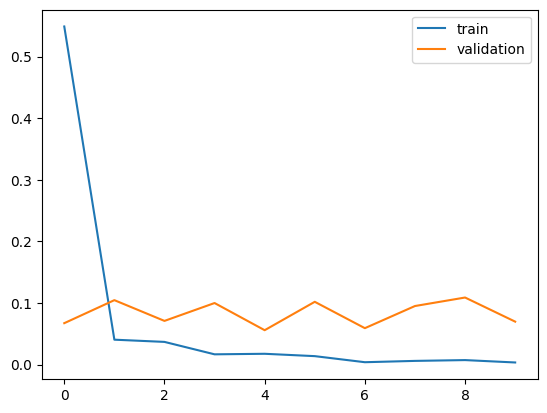

In [ ]:
# Training on ARDIS Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ADRIS_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/ARDIS_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on ADRIS test data
pretrained_weights = '/content/ADRIS_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8_input (InputLayer  [(None, 28, 28, 1)]       0         
 )                                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 20)        520       
                                                                 
 activation_12 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_13 (Activation)  (None, 14, 14, 50)        0   

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_15 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activ

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 0s - loss: 0.3026 - accuracy: 0.9271 - val_loss: 0.2222 - val_accuracy: 0.9438 - 200ms/epoch - 13ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.94375
15/15 - 0s - loss: 0.1541 - accuracy: 0.9573 - val_loss: 0.2028 - val_accuracy: 0.9417 - 248ms/epoch - 17ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.94375 to 0.94583, saving model to ./ARABIC_LeNet_MNIST_MIX/best_lenet.hdf5
15/15 - 0s - loss: 0.0771 - accuracy: 0.9724 - val_loss: 0.2344 - val_accuracy: 0.9458 - 301ms/epoch - 20ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.94583
15/15 - 0s - loss: 0.0691 - accuracy: 0.9771 - val_loss: 0.2429 - val_accuracy: 0.9354 - 171ms/epoch - 11ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.94583
15/15 - 0s - loss: 0.0636 - accuracy: 0.9766 - val_loss: 0.2462 - val_accuracy: 0.9458 - 155ms/epoch - 10ms/step
Epoch 7/10

Epoch 7: val_accuracy improved from 0.94583 to 0.95833, saving model to ./ARABIC_LeNet_MNIST_MIX/best_lenet.h

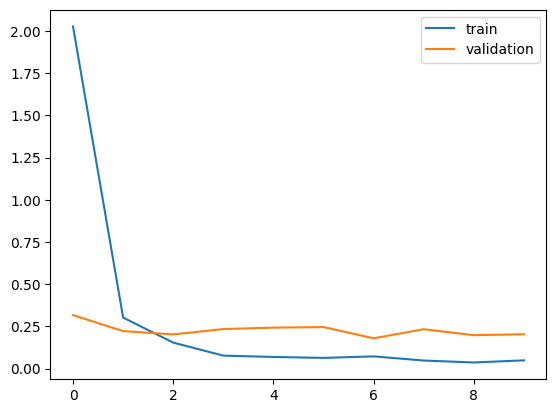

In [ ]:
# Training on CMATTERDB 3.3.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ARABIC_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Arabic_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTER 3.3.1 test data
pretrained_weights = '/content/ARABIC_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_18 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_19 (Activation)  (None, 14, 14, 50)        0  

(12638, 28, 28, 1)
(3160, 28, 28, 1)
(3950, 28, 28, 1)
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_21 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.92089 to 0.93101, saving model to ./BANGLALEKHA_LeNet_MNIST_MIX/best_lenet.hdf5
98/98 - 1s - loss: 0.2768 - accuracy: 0.9442 - val_loss: 0.3708 - val_accuracy: 0.9310 - 1s/epoch - 12ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.93101 to 0.93291, saving model to ./BANGLALEKHA_LeNet_MNIST_MIX/best_lenet.hdf5
98/98 - 1s - loss: 0.2354 - accuracy: 0.9510 - val_loss: 0.3904 - val_accuracy: 0.9329 - 614ms/epoch - 6ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.93291 to 0.93323, saving model to ./BANGLALEKHA_LeNet_MNIST_MIX/best_lenet.hdf5
98/98 - 1s - loss: 0.2046 - accuracy: 0.9577 - val_loss: 0.4066 - val_accuracy: 0.9332 - 602ms/epoch - 6ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.93323 to 0.93797, saving model to ./BANGLALEKHA_LeNet_MNIST_MIX/best_lenet.hdf5
98/98 - 1s - loss: 0.1936 - accuracy: 0.9596 - val_loss: 0.4015 - val_accuracy: 0.9380 - 626ms/epoch - 6ms/step
Epoch 6/10

Epoch 6: val_accuracy did not imp

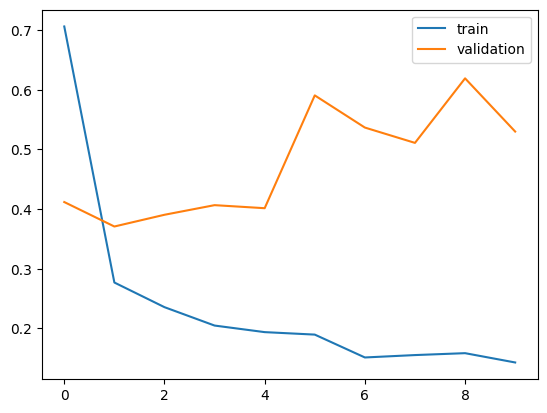

In [ ]:
# Training on BanglaLekha Isolated Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './BANGLALEKHA_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/BanglaLekha_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on BanglaLekha Isolated test data
pretrained_weights = '/content/BANGLALEKHA_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_24 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_25 (Activation)  (None, 14, 14, 50)        0  

(3840, 28, 28, 1)
(960, 28, 28, 1)
(1200, 28, 28, 1)
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_27 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 acti

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.93646 to 0.94271, saving model to ./BANGLA_LeNet_MNIST_MIX/best_lenet.hdf5
30/30 - 0s - loss: 0.1892 - accuracy: 0.9518 - val_loss: 0.2563 - val_accuracy: 0.9427 - 238ms/epoch - 8ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.94271 to 0.95729, saving model to ./BANGLA_LeNet_MNIST_MIX/best_lenet.hdf5
30/30 - 0s - loss: 0.1010 - accuracy: 0.9706 - val_loss: 0.1914 - val_accuracy: 0.9573 - 218ms/epoch - 7ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.95729
30/30 - 0s - loss: 0.0827 - accuracy: 0.9773 - val_loss: 0.3611 - val_accuracy: 0.9260 - 201ms/epoch - 7ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.95729
30/30 - 0s - loss: 0.0735 - accuracy: 0.9810 - val_loss: 0.2570 - val_accuracy: 0.9531 - 323ms/epoch - 11ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.95729 to 0.96667, saving model to ./BANGLA_LeNet_MNIST_MIX/best_lenet.hdf5
30/30 - 0s - loss: 0.0585 - accuracy: 0.9828 - val_loss: 0.24

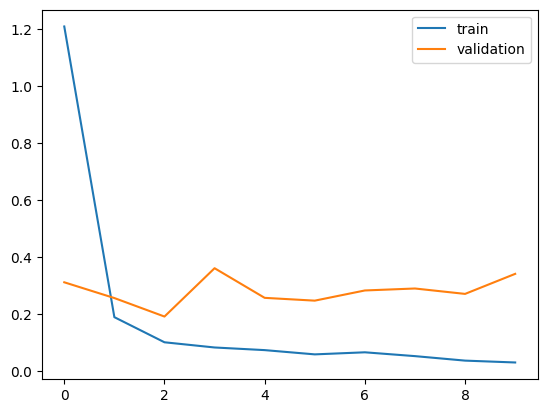

In [ ]:
# Training on CMATTERDB 3.1.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './BANGLA_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Bangla_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.1.1 test data
pretrained_weights = '/content/BANGLA_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_30 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_31 (Activation)  (None, 14, 14, 50)        0  

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_33 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activ

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_accuracy did not improve from 0.93750
15/15 - 0s - loss: 0.1134 - accuracy: 0.9661 - val_loss: 0.4995 - val_accuracy: 0.9354 - 108ms/epoch - 7ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.93750 to 0.94375, saving model to ./DEVANAGARI_LeNet_MNIST_MIX/best_lenet.hdf5
15/15 - 0s - loss: 0.0775 - accuracy: 0.9781 - val_loss: 0.5299 - val_accuracy: 0.9438 - 131ms/epoch - 9ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.94375 to 0.95625, saving model to ./DEVANAGARI_LeNet_MNIST_MIX/best_lenet.hdf5
15/15 - 0s - loss: 0.0364 - accuracy: 0.9891 - val_loss: 0.5353 - val_accuracy: 0.9563 - 134ms/epoch - 9ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.95625
15/15 - 0s - loss: 0.0462 - accuracy: 0.9880 - val_loss: 0.5198 - val_accuracy: 0.9542 - 147ms/epoch - 10ms/step
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.95625
15/15 - 0s - loss: 0.0384 - accuracy: 0.9896 - val_loss: 0.4956 - val_accuracy: 0.9563 - 108ms/epoch - 7ms/step
Epo

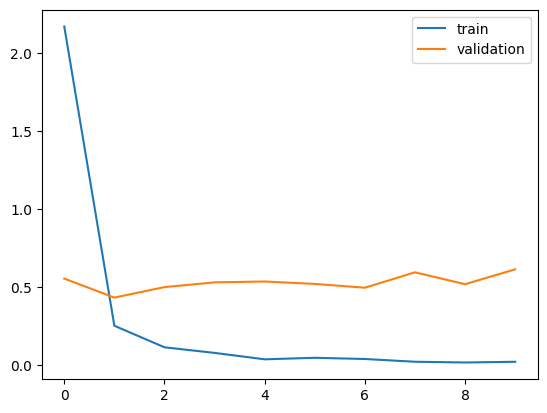

In [ ]:
# Training on CMATTERDB 3.2.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './DEVANAGARI_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Devanagari_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.2.1 test data
pretrained_weights = '/content/DEVANAGARI_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_36 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_37 (Activation)  (None, 14, 14, 50)        0  

(192000, 28, 28, 1)
(48000, 28, 28, 1)
(40000, 28, 28, 1)
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_39 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.99296 to 0.99423, saving model to ./EMNIST_LeNet_MNIST_MIX/best_lenet.hdf5
1500/1500 - 9s - loss: 0.1115 - accuracy: 0.9935 - val_loss: 0.1270 - val_accuracy: 0.9942 - 9s/epoch - 6ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.99423 to 0.99467, saving model to ./EMNIST_LeNet_MNIST_MIX/best_lenet.hdf5
1500/1500 - 15s - loss: 0.1045 - accuracy: 0.9944 - val_loss: 0.1440 - val_accuracy: 0.9947 - 15s/epoch - 10ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.99467
1500/1500 - 12s - loss: 0.0988 - accuracy: 0.9951 - val_loss: 0.1616 - val_accuracy: 0.9940 - 12s/epoch - 8ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.99467
1500/1500 - 10s - loss: 0.0967 - accuracy: 0.9953 - val_loss: 0.1701 - val_accuracy: 0.9939 - 10s/epoch - 7ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.99467
1500/1500 - 10s - loss: 0.0913 - accuracy: 0.9957 - val_loss: 0.1864 - val_accuracy: 0.9938 - 10s/epoch - 7ms/ste

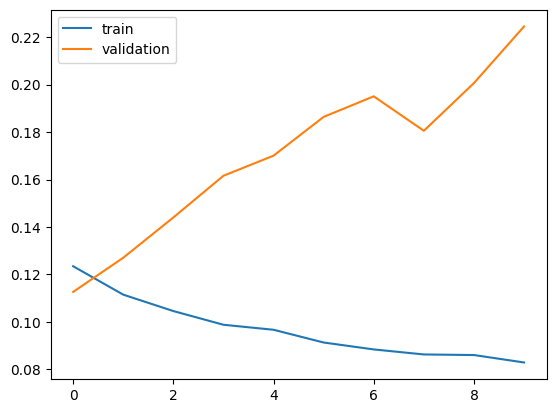

In [ ]:
# Training on EMNIST Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './EMNIST_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/EMNIST_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on EMNIST test data
pretrained_weights = '/content/EMNIST_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_42 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_43 (Activation)  (None, 14, 14, 50)        0  

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(20000, 28, 28, 1)
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_45 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.98167
375/375 - 3s - loss: 0.1109 - accuracy: 0.9821 - val_loss: 0.1870 - val_accuracy: 0.9772 - 3s/epoch - 7ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.98167 to 0.98358, saving model to ./FARSI_LeNet_MNIST_MIX/best_lenet.hdf5
375/375 - 3s - loss: 0.1048 - accuracy: 0.9855 - val_loss: 0.1246 - val_accuracy: 0.9836 - 3s/epoch - 7ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.98358 to 0.98617, saving model to ./FARSI_LeNet_MNIST_MIX/best_lenet.hdf5
375/375 - 3s - loss: 0.0891 - accuracy: 0.9885 - val_loss: 0.1213 - val_accuracy: 0.9862 - 3s/epoch - 7ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.98617
375/375 - 3s - loss: 0.0862 - accuracy: 0.9889 - val_loss: 0.1429 - val_accuracy: 0.9817 - 3s/epoch - 7ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.98617
375/375 - 3s - loss: 0.0794 - accuracy: 0.9899 - val_loss: 0.1699 - val_accuracy: 0.9820 - 3s/epoch - 7ms/step
Epoch 7/10

Epoch 7

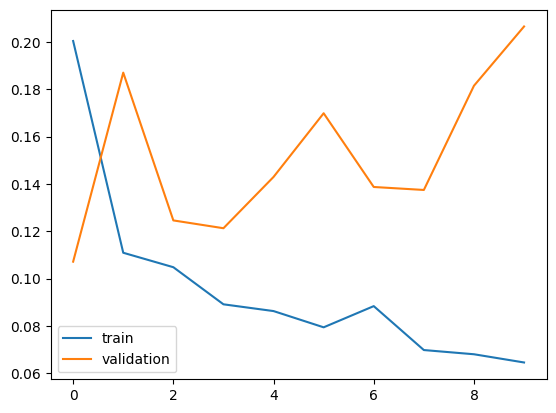

In [ ]:
# Training on FARSI Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './FARSI_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Farsi_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on FARSI test data
pretrained_weights = '/content/FARSI_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_48 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_49 (Activation)  (None, 14, 14, 50)        0  

(15513, 28, 28, 1)
(3879, 28, 28, 1)
(4000, 28, 28, 1)
Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_34 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_51 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.95746 to 0.96236, saving model to ./ISIBANGLA_LeNet_MNIST_MIX/best_lenet.hdf5
121/121 - 1s - loss: 0.1422 - accuracy: 0.9669 - val_loss: 0.1906 - val_accuracy: 0.9624 - 827ms/epoch - 7ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.96236
121/121 - 1s - loss: 0.1170 - accuracy: 0.9742 - val_loss: 0.3091 - val_accuracy: 0.9441 - 766ms/epoch - 6ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.96236 to 0.96778, saving model to ./ISIBANGLA_LeNet_MNIST_MIX/best_lenet.hdf5
121/121 - 1s - loss: 0.1022 - accuracy: 0.9779 - val_loss: 0.1825 - val_accuracy: 0.9678 - 734ms/epoch - 6ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.96778 to 0.96932, saving model to ./ISIBANGLA_LeNet_MNIST_MIX/best_lenet.hdf5
121/121 - 1s - loss: 0.1019 - accuracy: 0.9790 - val_loss: 0.2008 - val_accuracy: 0.9693 - 736ms/epoch - 6ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.96932
121/121 - 1s - loss: 0.0790 - accuracy: 0.983

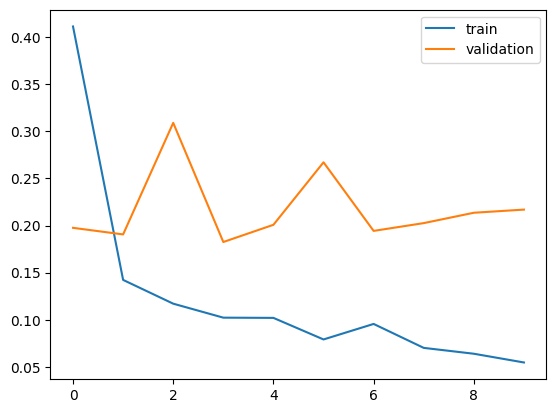

In [ ]:
# Training on ISI BANGLA Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ISIBANGLA_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/ISI_Bangla_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on ISI BANGLA test data
pretrained_weights = '/content/ISIBANGLA_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_54 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_55 (Activation)  (None, 14, 14, 50)        0  

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(20240, 28, 28, 1)
Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_38 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_57 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.98783 to 0.98975, saving model to ./KANNADA_LeNet_MNIST_MIX/best_lenet.hdf5
375/375 - 3s - loss: 0.0634 - accuracy: 0.9888 - val_loss: 0.0637 - val_accuracy: 0.9898 - 3s/epoch - 8ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.98975
375/375 - 2s - loss: 0.0613 - accuracy: 0.9905 - val_loss: 0.0666 - val_accuracy: 0.9898 - 2s/epoch - 6ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.98975 to 0.99050, saving model to ./KANNADA_LeNet_MNIST_MIX/best_lenet.hdf5
375/375 - 2s - loss: 0.0571 - accuracy: 0.9915 - val_loss: 0.0705 - val_accuracy: 0.9905 - 2s/epoch - 5ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.99050 to 0.99083, saving model to ./KANNADA_LeNet_MNIST_MIX/best_lenet.hdf5
375/375 - 3s - loss: 0.0445 - accuracy: 0.9935 - val_loss: 0.0716 - val_accuracy: 0.9908 - 3s/epoch - 7ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.99083
375/375 - 3s - loss: 0.0421 - accuracy: 0.9943 - val_loss: 0.09

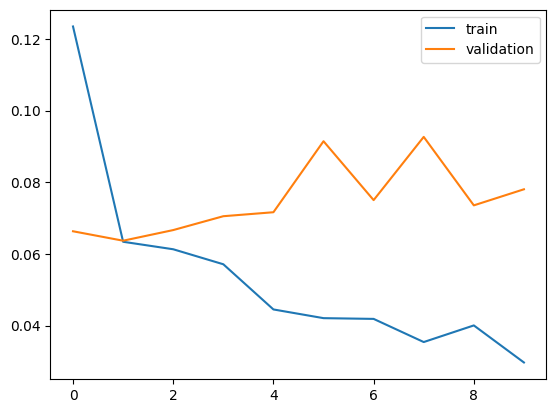

In [ ]:
# Training on Kannada Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './KANNADA_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Kannada_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on kannada test data
pretrained_weights = '/content/KANNADA_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_63 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_64 (Activation)  (None, 14, 14, 50)        0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_44 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_66 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.98958 to 0.99017, saving model to ./MADBASE_LeNet_MNIST_MIX/best_lenet.hdf5
375/375 - 3s - loss: 0.0864 - accuracy: 0.9907 - val_loss: 0.1285 - val_accuracy: 0.9902 - 3s/epoch - 7ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.99017
375/375 - 4s - loss: 0.0784 - accuracy: 0.9927 - val_loss: 0.1232 - val_accuracy: 0.9897 - 4s/epoch - 10ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.99017 to 0.99308, saving model to ./MADBASE_LeNet_MNIST_MIX/best_lenet.hdf5
375/375 - 4s - loss: 0.0659 - accuracy: 0.9941 - val_loss: 0.1067 - val_accuracy: 0.9931 - 4s/epoch - 10ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.99308
375/375 - 3s - loss: 0.0606 - accuracy: 0.9945 - val_loss: 0.1486 - val_accuracy: 0.9912 - 3s/epoch - 8ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.99308
375/375 - 2s - loss: 0.0568 - accuracy: 0.9948 - val_loss: 0.1483 - val_accuracy: 0.9923 - 2s/epoch - 6ms/step
Epoch 7/10

E

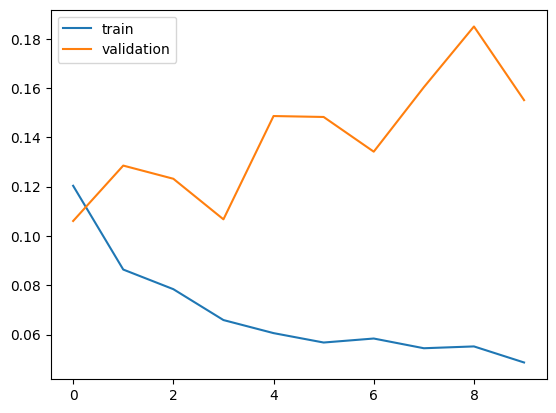

In [ ]:
# Training on MADBASE Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './MADBASE_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/MADBase_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on MADBASE test data
pretrained_weights = '/content/MADBASE_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_46 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_69 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_70 (Activation)  (None, 14, 14, 50)        0  

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_48 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_72 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activ

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_accuracy did not improve from 0.95625
15/15 - 0s - loss: 0.0693 - accuracy: 0.9797 - val_loss: 0.1859 - val_accuracy: 0.9542 - 156ms/epoch - 10ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.95625 to 0.96875, saving model to ./TELUGU_LeNet_MNIST_MIX/best_lenet.hdf5
15/15 - 0s - loss: 0.0319 - accuracy: 0.9880 - val_loss: 0.1410 - val_accuracy: 0.9688 - 138ms/epoch - 9ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.96875
15/15 - 0s - loss: 0.0237 - accuracy: 0.9922 - val_loss: 0.1810 - val_accuracy: 0.9583 - 112ms/epoch - 7ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.96875
15/15 - 0s - loss: 0.0179 - accuracy: 0.9927 - val_loss: 0.1742 - val_accuracy: 0.9604 - 171ms/epoch - 11ms/step
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.96875
15/15 - 0s - loss: 0.0189 - accuracy: 0.9932 - val_loss: 0.1980 - val_accuracy: 0.9625 - 162ms/epoch - 11ms/step
Epoch 8/10

Epoch 8: val_accuracy did not improve from 0.96875
15/15 - 

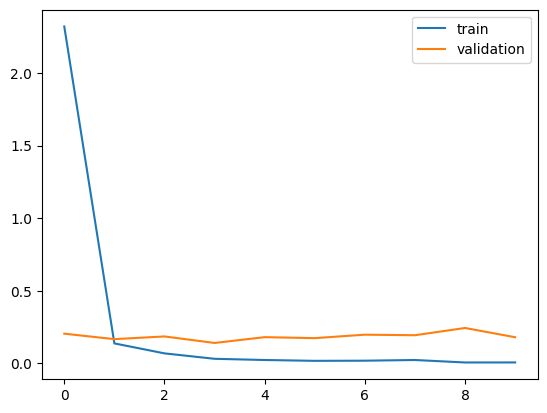

In [ ]:
# Training on CMATTERDB 3.4.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './TELUGU_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Telugu_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.4.1 test data
pretrained_weights = '/content/TELUGU_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_50 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_75 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_76 (Activation)  (None, 14, 14, 50)        0  

(11371, 28, 28, 1)
(2843, 28, 28, 1)
(3554, 28, 28, 1)
Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_52 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_78 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.95990
88/88 - 1s - loss: 0.1500 - accuracy: 0.9658 - val_loss: 0.2285 - val_accuracy: 0.9504 - 525ms/epoch - 6ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.95990 to 0.96905, saving model to ./TIBETAN_LeNet_MNIST_MIX/best_lenet.hdf5
88/88 - 1s - loss: 0.1146 - accuracy: 0.9724 - val_loss: 0.1810 - val_accuracy: 0.9690 - 651ms/epoch - 7ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.96905 to 0.97292, saving model to ./TIBETAN_LeNet_MNIST_MIX/best_lenet.hdf5
88/88 - 1s - loss: 0.1000 - accuracy: 0.9784 - val_loss: 0.1705 - val_accuracy: 0.9729 - 542ms/epoch - 6ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.97292
88/88 - 1s - loss: 0.0937 - accuracy: 0.9790 - val_loss: 0.1810 - val_accuracy: 0.9708 - 625ms/epoch - 7ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.97292 to 0.97503, saving model to ./TIBETAN_LeNet_MNIST_MIX/best_lenet.hdf5
88/88 - 1s - loss: 0.0825 - accuracy: 0.9816 - val_loss: 0.

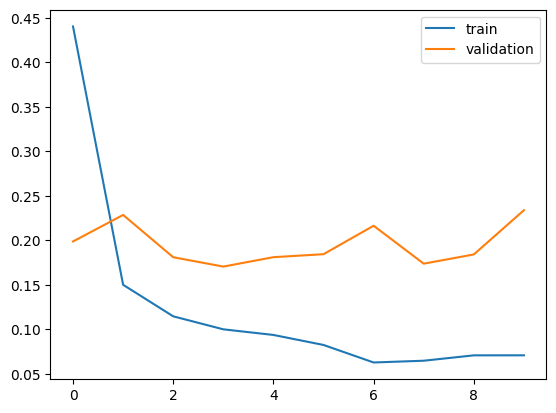

In [ ]:
# Training on Tibetan Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './TIBETAN_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Tibetan_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on TIBETAN test data
pretrained_weights = '/content/TIBETAN_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_54 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_81 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_82 (Activation)  (None, 14, 14, 50)        0  

(5284, 28, 28, 1)
(1322, 28, 28, 1)
(1414, 28, 28, 1)
Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_56 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_84 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_57 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 act

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.93722
41/41 - 0s - loss: 0.1461 - accuracy: 0.9646 - val_loss: 0.3427 - val_accuracy: 0.9327 - 274ms/epoch - 7ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.93722 to 0.94251, saving model to ./URDU_LeNet_MNIST_MIX/best_lenet.hdf5
41/41 - 0s - loss: 0.1338 - accuracy: 0.9684 - val_loss: 0.3133 - val_accuracy: 0.9425 - 301ms/epoch - 7ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.94251 to 0.94554, saving model to ./URDU_LeNet_MNIST_MIX/best_lenet.hdf5
41/41 - 0s - loss: 0.0925 - accuracy: 0.9750 - val_loss: 0.3566 - val_accuracy: 0.9455 - 347ms/epoch - 8ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.94554 to 0.95310, saving model to ./URDU_LeNet_MNIST_MIX/best_lenet.hdf5
41/41 - 0s - loss: 0.1006 - accuracy: 0.9779 - val_loss: 0.3219 - val_accuracy: 0.9531 - 299ms/epoch - 7ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.95310 to 0.95386, saving model to ./URDU_LeNet_MNIST_MIX/best_lenet.hdf5
41/41 - 

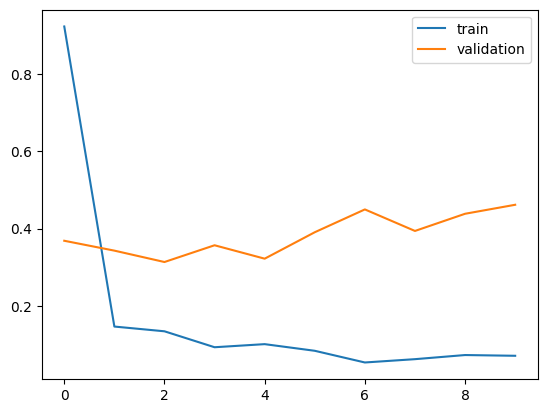

In [ ]:
# Training on URDU Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './URDU_LeNet_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Urdu_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on URDU test data
pretrained_weights = '/content/URDU_LeNet_MNIST_MIX/best_lenet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_58 (Conv2D)          (None, 28, 28, 20)        520       
                                                                 
 activation_87 (Activation)  (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 14, 14, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 14, 14, 50)        25050     
                                                                 
 activation_88 (Activation)  (None, 14, 14, 50)        0  